# Modelo sin Pre-Entrenar

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Definir los directorios donde se encuentran los datos de entrenamiento, prueba y validación
train_dir = Path(r'C:\Users\Mech\Downloads\fruit-and-vegetable-classification\train')  # Cambia la ruta si es necesario
test_dir = Path(r'C:\Users\Mech\Downloads\fruit-and-vegetable-classification\test')  # Cambia la ruta si es necesario
val_dir = Path(r'C:\Users\Mech\Downloads\fruit-and-vegetable-classification\validation')  # Cambia la ruta si es necesario

# Crear listas con las rutas de los archivos de imágenes para entrenamiento, prueba y validación
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """Crear un DataFrame con las rutas de los archivos y las etiquetas de las imágenes."""
    
    # Extraer las etiquetas de las imágenes a partir de la estructura de carpetas
    # El nombre de la penúltima carpeta es la etiqueta
    labels = [str(filepath[i]).split(os.path.sep)[-2] for i in range(len(filepath))]

    # Crear las series de pandas para las rutas de los archivos y las etiquetas
    filepath_series = pd.Series(filepath, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenar las rutas de los archivos y las etiquetas en un DataFrame
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Barajar aleatoriamente las filas del DataFrame y reiniciar los índices
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

# Procesar las imágenes para los conjuntos de datos de entrenamiento, prueba y validación
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# Mostrar las primeras filas de los DataFrames para verificar
print("DataFrame de entrenamiento:")
print(train_df.head())
print("DataFrame de prueba:")
print(test_df.head())
print("DataFrame de validación:")
print(val_df.head())

DataFrame de entrenamiento:
                                            Filepath     Label
0  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...  capsicum
1  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...   spinach
2  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...     mango
3  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...    potato
4  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...    orange
DataFrame de prueba:
                                            Filepath        Label
0  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...       banana
1  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...     cucumber
2  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...  cauliflower
3  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...     eggplant
4  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...         peas
DataFrame de validación:
                                            Filepath       Label
0  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...  watermelon
1  C:\Users\Mech\Downl

In [4]:
# Preparar los generadores para cargar las imágenes y sus etiquetas
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


# Creacion de la Red Neuronal


Para la creacion de esta red se hacen 10 capas, en esta estructura:

* Primera capa convolucional.
* Segunda capa convolucional.
* Max pooling después de la segunda convolución.
* Tercera capa convolucional.
* Max pooling después de la tercera convolución.
* Aplana las salidas de las capas anteriores para conectarlas a las capas densas.
* Capa densa con 128 neuronas.
* Capa de salida con 36 neuronas (para clasificación con 36 clases).


In [5]:
# Crear un modelo secuencial sin usar un modelo preentrenado
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(36, activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Entrenar el modelo
history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=5,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=2,
        restore_best_weights=True
    )]
)



Epoch 1/5
90/90 [==============================] - 45s 502ms/step - loss: 3.3685 - accuracy: 0.1033 - val_loss: 2.4345 - val_accuracy: 0.3118
Epoch 2/5
90/90 [==============================] - 39s 427ms/step - loss: 2.4689 - accuracy: 0.2921 - val_loss: 1.6625 - val_accuracy: 0.6059
Epoch 3/5
90/90 [==============================] - 38s 419ms/step - loss: 1.9218 - accuracy: 0.4333 - val_loss: 0.9653 - val_accuracy: 0.7294
Epoch 4/5
90/90 [==============================] - 37s 410ms/step - loss: 1.3518 - accuracy: 0.6049 - val_loss: 0.5586 - val_accuracy: 0.8647
Epoch 5/5
90/90 [==============================] - 37s 413ms/step - loss: 0.6647 - accuracy: 0.8046 - val_loss: 0.4454 - val_accuracy: 0.9206


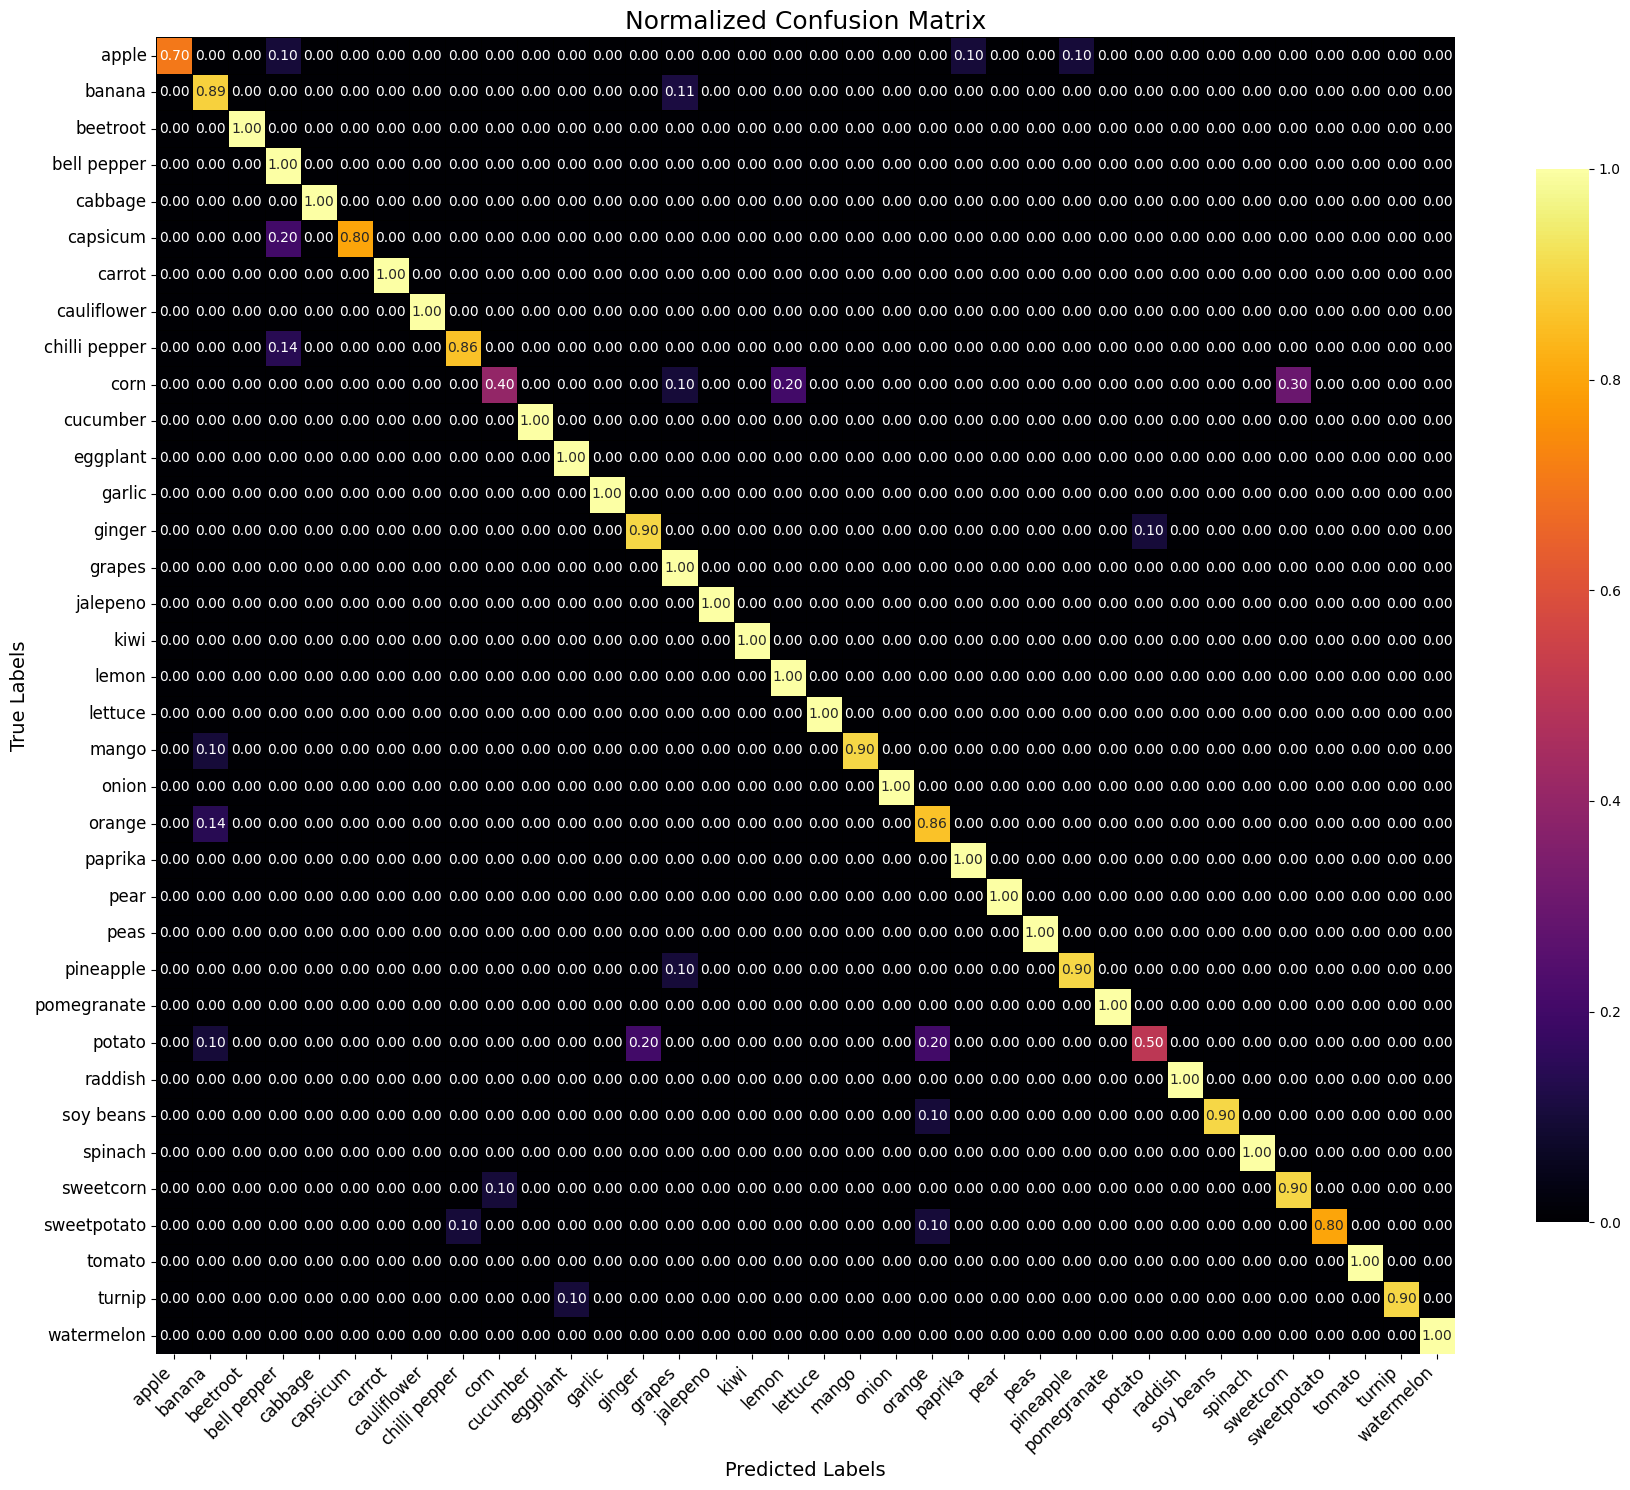

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión normalizada
cf_matrix = confusion_matrix(y_test, pred, normalize='true')

# Ajustar la visualización de la matriz de confusión
plt.figure(figsize=(18, 15), facecolor='white')  # Fondo blanco para la figura
sns.heatmap(cf_matrix, annot=True, fmt='.2f', xticklabels=class_names, yticklabels=class_names,
            cmap='inferno', cbar=True, annot_kws={'size': 10}, linewidths=0.5, linecolor='black', 
            cbar_kws={'shrink': 0.8})  # Bordes entre las celdas

# Mejorar la legibilidad con título y etiquetas
plt.title('Normalized Confusion Matrix', fontsize=18)
plt.xlabel('Predicted Labels', fontsize=14)
plt.ylabel('True Labels', fontsize=14)
plt.xticks(rotation=45, ha="right", fontsize=12)  # Rotar las etiquetas X para mayor claridad
plt.yticks(rotation=0, fontsize=12)  # Mantener las etiquetas Y horizontales
plt.tight_layout()  # Ajustar el espaciado para que todo encaje bien
plt.show()



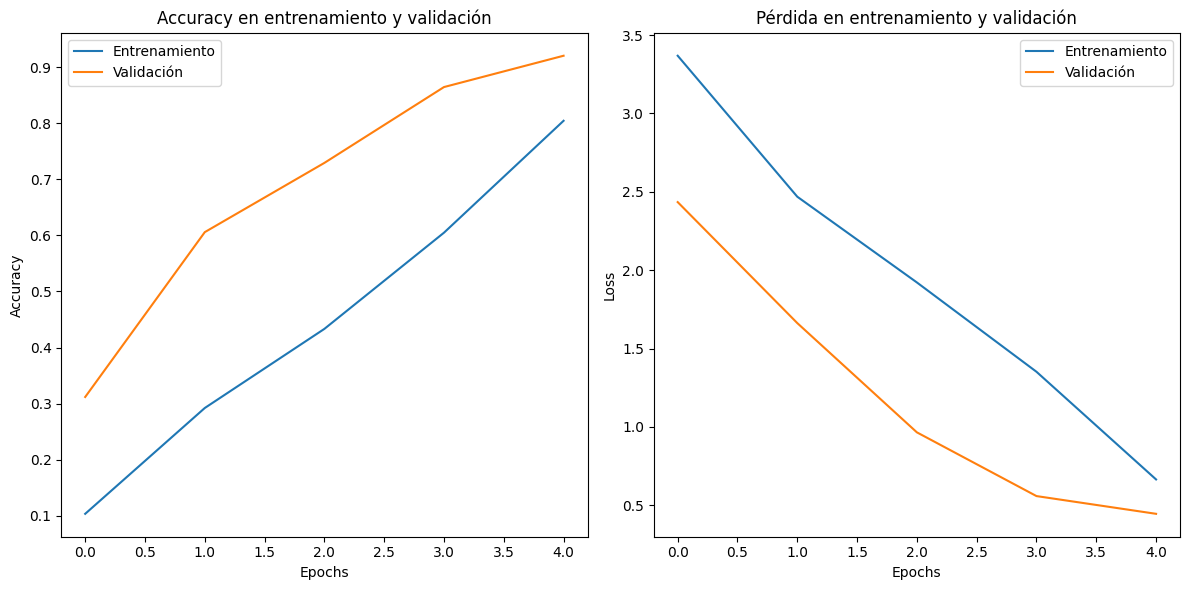

In [17]:
# Graficar el rendimiento del modelo durante el entrenamiento
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Entrenamiento')
plt.plot(history.history['val_accuracy'], label='Validación')
plt.title('Accuracy en entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

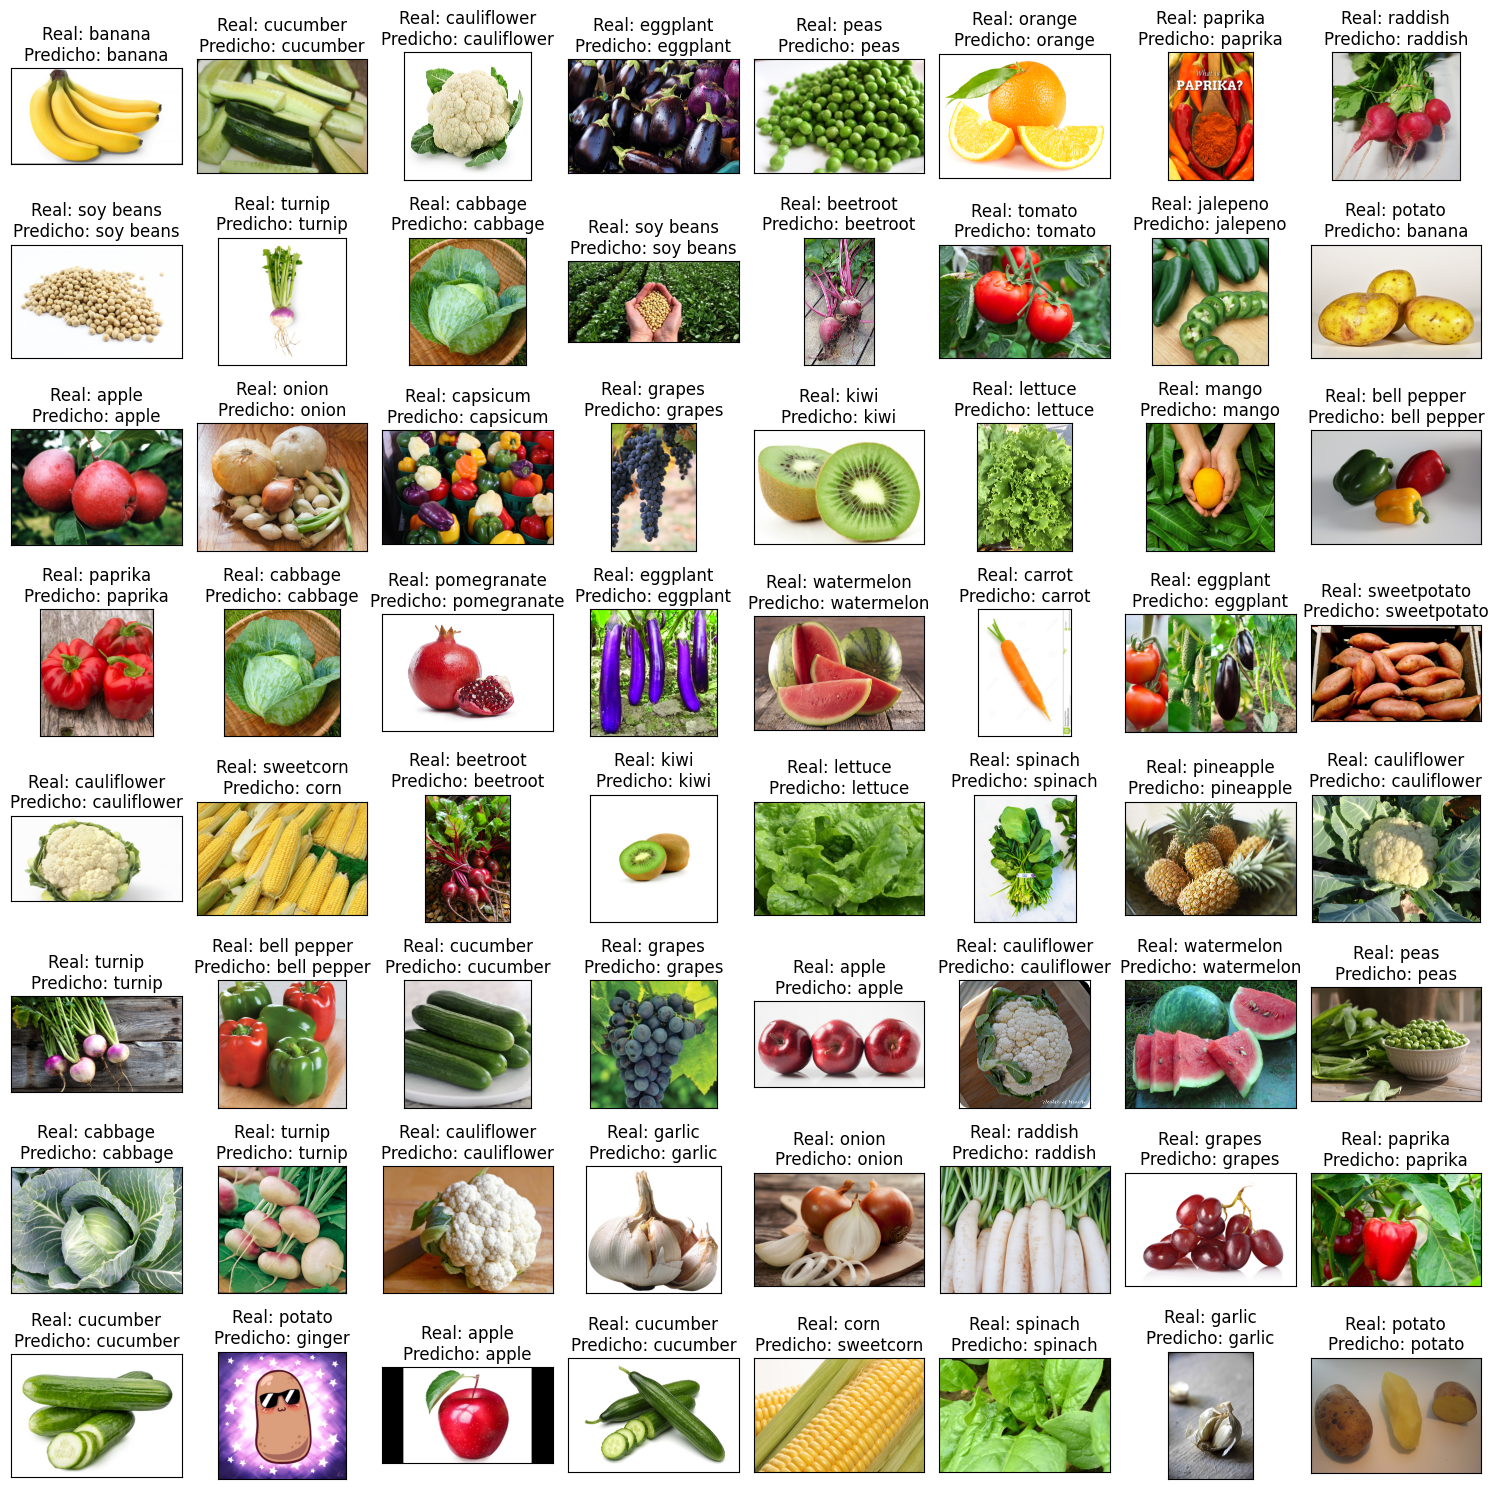

In [19]:
# Mostrar algunas imágenes del conjunto de prueba con sus etiquetas y las predicciones
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 15),  # Crear una figura con 3 filas y 3 columnas de subgráficos
                        subplot_kw={'xticks': [], 'yticks': []})  # Eliminar las marcas de los ejes X y Y

# Iterar sobre los subgráficos y mostrar las imágenes junto con sus etiquetas reales y predicciones
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))  # Leer y mostrar la imagen desde el DataFrame de prueba
    # Obtener las etiquetas correspondientes a los índices de predicción
    pred_label = class_names[pred[i]]
    ax.set_title(f"Real: {test_df.Label.iloc[i]}\nPredicho: {pred_label}")


# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar el gráfico final
plt.style.use('default')
plt.show()

In [20]:
from sklearn.metrics import classification_report

# Generar el reporte de clasificación (F1-score, precisión, recall)
print(classification_report(y_test, pred, target_names=train_images.class_indices.keys()))

               precision    recall  f1-score   support

        apple       1.00      0.70      0.82        10
       banana       0.73      0.89      0.80         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.69      1.00      0.82         9
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.80      0.89        10
       carrot       1.00      1.00      1.00         8
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.86      0.86      0.86         7
         corn       0.80      0.40      0.53        10
     cucumber       1.00      1.00      1.00        10
     eggplant       0.91      1.00      0.95        10
       garlic       1.00      1.00      1.00        10
       ginger       0.82      0.90      0.86        10
       grapes       0.75      1.00      0.86         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00      1.00        10
        l